<img src="images/arm_logo.png" width=500 alt="ARM Logo"></img>

# Bankhead National Forest - RadClss Example

## Overview

The Extracted Radar Columns and In-Situ Sensors (RadClss) Value-Added Product (VAP) is
a dataset containing in-situ ground observations matched to CSAPR-2 radar columns above ARM Mobile Facility (AMF-3) supplemental sites of interest. 

RadCLss is intended to provide a dataset for algorthim development and validation of precipitation retrievals.

## Prerequisites

| Concepts | Importance | Notes |
| --- | --- | --- |
| [Intro to Cartopy](https://foundations.projectpythia.org/core/cartopy/cartopy.html) | Necessary | |
| [Understanding of NetCDF](https://foundations.projectpythia.org/core/data-formats/netcdf-cf.html) | Helpful | Familiarity with metadata structure |
| [GeoPandas](https://geopandas.org/en/stable/docs.html) | Necessary | Familiarity with Geospatial Plotting|
| [Py-ART / Radar Foundations](https://projectpythia.org/radar-cookbook/README.html) | Necessary | Basics of Weather Radar | 

- **Time to learn**: 30 minutes

## Current List of Supported Sites of Interest
| Site  | Lat   | Lon   |
| ----- | ----- | ----- |
| M1    | 34.34525 | -87.33842 |
| S4    | 34.46451 | -87.23598 |
| S20   | 34.65401 | -87.29264 |
| S30   | 34.38501 | -86.92757 |
| S40   | 34.17932 | -87.45349 |
| S10   | 34.343611 | -87.350278 |

## Pending List of Supported Sites of Interest
| Site  | Lat   | Lon   |
| ----- | ----- | ----- |
| S13    | 34.343889 | -87.350556 |
| S14    | 34.343333 | -87.350833 |

<img src="images/bnf-in-situ-locations.png" width=1500 alt="BNF Sensors"></img>

In [47]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

import os
import glob
import datetime

import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import pandas as pd
import dask
import cartopy.crs as ccrs

from math import atan2 as atan2
from cartopy import crs as ccrs, feature as cfeature
from cartopy.io.img_tiles import OSM
from matplotlib.transforms import offset_copy
from dask.distributed import Client, LocalCluster
from metpy.plots import USCOUNTIES

import act
import pyart

dask.config.set({'logging.distributed': 'error'})

## Define Processing Variables

In [48]:
# Define the desired processing date for the BNF CSAPR-2 in YYYY-MM-DD format.
DATE = "2025-03-05"
RADAR_DIR = os.getenv("BNF_RADAR_R5_DIR") + "202503/"
INSITU_DIR = os.getenv("BNF_INSITU_DIR")

In [49]:
# Define ARM Username and ARM Token with ARM Live service for downloading ground instrumentation via ACT.DISCOVERY
# With your ARM username, you can find your ARM Live token here: https://adc.arm.gov/armlive/
ARM_USERNAME = os.getenv("ARM_USERNAME")
ARM_TOKEN = os.getenv("ARM_TOKEN")

In [50]:
# define the in-situ datastreams and output directory
insitu_stream = {'bnfmetM1.b1' : INSITU_DIR + 'bnfmetM1.b1',
                 'bnfmetS20.b1' : INSITU_DIR + "bnfmetS20.b1",
                 "bnfmetS30.b1" : INSITU_DIR + "bnfmetS30.b1",
                 "bnfmetS40.b1" : INSITU_DIR + "bnfmetS40.b1",
                 "bnfsondewnpnM1.b1" : INSITU_DIR + "bnfsondewnpnM1.b1",
                 "bnfwbpluvio2M1.a1" : INSITU_DIR + "bnfwbpluvio2M1.a1",
                 "bnfldquantsM1.c1" : INSITU_DIR + "bnfldquantsM1.c1",
                 "bnfldquantsS30.c1" : INSITU_DIR + "bnfldquantsS30.c1",
                 "bnfvdisquantsM1.c1" : INSITU_DIR + "bnfvdisquantsM1.c1",
                 "bnfmetwxtS13.b1" : INSITU_DIR + "bnfmetwxtS13.b1"
                }

In [51]:
# Define variables to drop from RadCLss from the respective datastreams 
discard_var = {'radar' : ['classification_mask',
                          'censor_mask',
                          'uncorrected_copol_correlation_coeff',
                          'uncorrected_differential_phase',
                          'uncorrected_differential_reflectivity',
                          'uncorrected_differential_reflectivity_lag_1',
                          'uncorrected_mean_doppler_velocity_h',
                          'uncorrected_mean_doppler_velocity_v',
                          'uncorrected_reflectivity_h',
                          'uncorrected_reflectivity_v',
                          'uncorrected_spectral_width_h',
                          'uncorrected_spectral_width_v',
                          'clutter_masked_velocity',
                          'gate_id',
                          'ground_clutter',
                          'partial_beam_blockage',
                          'cumulative_beam_blockage',
                          'unfolded_differential_phase',
                          'path_integrated_attenuation',
                          'path_integrated_differential_attenuation',
                          'unthresholded_power_copolar_v',
                          'unthresholded_power_copolar_h',
                          'specific_differential_phase',
                          'specific_differential_attenuation',
                          'reflectivity_v',
                          'reflectivity',
                          'mean_doppler_velocity_v',
                          'mean_doppler_velocity',
                          'differential_reflectivity_lag_1',
                          'differential_reflectivity',
                          'differential_phase',
                          'normalized_coherent_power',
                          'normalized_coherent_power_v',
                          'signal_to_noise_ratio_copolar_h',
                          'signal_to_noise_ratio_copolar_v',
                          'specific_attenuation',
                          'spectral_width',
                          'spectral_width_v',
                          'sounding_temperature',
                          'signal_to_noise_ratio',
                          'velocity_texture',
                          'simulated_velocity',
                          'height_over_iso0',
                ],
                'met' : ['base_time', 'time_offset', 'time_bounds', 'logger_volt',
                        'logger_temp', 'qc_logger_temp', 'lat', 'lon', 'alt', 'qc_temp_mean',
                        'qc_rh_mean', 'qc_vapor_pressure_mean', 'qc_wspd_arith_mean', 'qc_wspd_vec_mean',
                        'qc_wdir_vec_mean', 'qc_pwd_mean_vis_1min', 'qc_pwd_mean_vis_10min', 'qc_pwd_pw_code_inst',
                        'qc_pwd_pw_code_15min', 'qc_pwd_pw_code_1hr', 'qc_pwd_precip_rate_mean_1min',
                        'qc_pwd_cumul_rain', 'qc_pwd_cumul_snow', 'qc_org_precip_rate_mean', 'qc_tbrg_precip_total',
                        'qc_tbrg_precip_total_corr', 'qc_logger_volt', 'qc_logger_temp', 'qc_atmos_pressure', 
                        'pwd_pw_code_inst', 'pwd_pw_code_15min', 'pwd_pw_code_1hr', 'temp_std', 'rh_std',
                        'vapor_pressure_std', 'wdir_vec_std', 'tbrg_precip_total', 'org_precip_rate_mean',
                        'pwd_mean_vis_1min', 'pwd_mean_vis_10min', 'pwd_precip_rate_mean_1min', 'pwd_cumul_rain',
                        'pwd_cumul_snow', 'pwd_err_code'
                ],
                'sonde' : ['base_time', 'time_offset', 'lat', 'lon', 'qc_pres',
                           'qc_tdry', 'qc_dp', 'qc_wspd', 'qc_deg', 'qc_rh',
                           'qc_u_wind', 'qc_v_wind', 'qc_asc', "wstat", "asc"
                ],
                'pluvio' : ['base_time', 'time_offset', 'load_cell_temp', 'heater_status',
                            'elec_unit_temp', 'supply_volts', 'orifice_temp', 'volt_min',
                            'ptemp', 'lat', 'lon', 'alt', 'maintenance_flag', 'reset_flag', 
                            'qc_rh_mean', 'pluvio_status', 'bucket_rt', 'accum_total_nrt'
                ],
                'ldquants' : ['specific_differential_attenuation_xband20c',
                              'specific_differential_attenuation_kaband20c',
                              'specific_differential_attenuation_sband20c',
                              'bringi_conv_stra_flag',
                              'exppsd_slope',
                              'norm_num_concen',
                              'num_concen',
                              'gammapsd_shape',
                              'gammapsd_slope',
                              'mean_doppler_vel_wband20c',
                              'mean_doppler_vel_kaband20c',
                              'mean_doppler_vel_xband20c',
                              'mean_doppler_vel_sband20c',
                              'specific_attenuation_kaband20c',
                              'specific_attenuation_xband20c',
                              'specific_attenuation_sband20c',
                              'specific_differential_phase_kaband20c',
                              'specific_differential_phase_xband20c',
                              'specific_differential_phase_sband20c',
                              'differential_reflectivity_kaband20c',
                              'differential_reflectivity_xband20c',
                              'differential_reflectivity_sband20c',
                              'reflectivity_factor_wband20c',
                              'reflectivity_factor_kaband20c',
                              'reflectivity_factor_xband20c',
                              'reflectivity_factor_sband20c',
                              'bringi_conv_stra_flag',
                              'time_offset',
                              'base_time',
                              'lat',
                              'lon',
                              'alt'
                ],
                'vdisquants' : ['specific_differential_attenuation_xband20c',
                                'specific_differential_attenuation_kaband20c',
                                'specific_differential_attenuation_sband20c',
                                'bringi_conv_stra_flag',
                                'exppsd_slope',
                                'norm_num_concen',
                                'num_concen',
                                'gammapsd_shape',
                                'gammapsd_slope',
                                'mean_doppler_vel_wband20c',
                                'mean_doppler_vel_kaband20c',
                                'mean_doppler_vel_xband20c',
                                'mean_doppler_vel_sband20c',
                                'specific_attenuation_kaband20c',
                                'specific_attenuation_xband20c',
                                'specific_attenuation_sband20c',
                                'specific_differential_phase_kaband20c',
                                'specific_differential_phase_xband20c',
                                'specific_differential_phase_sband20c',
                                'differential_reflectivity_kaband20c',
                                'differential_reflectivity_xband20c',
                                'differential_reflectivity_sband20c',
                                'reflectivity_factor_wband20c',
                                'reflectivity_factor_kaband20c',
                                'reflectivity_factor_xband20c',
                                'reflectivity_factor_sband20c',
                                'bringi_conv_stra_flag',
                                'time_offset',
                                'base_time',
                                'lat',
                                'lon',
                                'alt'
                ],
                'wxt' : ['base_time',
                         'time_offset',
                         'time_bounds',
                         'temp_mean',
                         'qc_temp_mean',
                         'temp_std',
                         'rh_mean',
                         'qc_rh_mean',
                         'rh_std',
                         'atmos_pressure',
                         'qc_atmos_pressure',
                         'wspd_arith_mean',
                         'qc_wspd_arith_mean',
                         'wspd_vec_mean',
                         'qc_wspd_vec_mean',
                         'wdir_vec_mean',
                         'qc_wdir_vec_mean',
                         'wdir_vec_std',
                         'qc_wxt_precip_rate_mean',
                         'qc_wxt_cumul_precip',
                         'logger_volt',
                         'qc_logger_volt',
                         'logger_temp',
                         'qc_logger_temp',
                         'lat',
                         'lon',
                         'alt'
                ]
}

## Define Functions 

In [52]:
def subset_points(nfile, **kwargs):
    """
    Subset a radar file for a set of latitudes and longitudes
    utilizing Py-ART's column-vertical-profile functionality.

    Parameters
    ----------
    file : str
        Path to the radar file to extract columns from
    nsonde : list
        List containing file paths to the desired sonde file to merge

    Calls
    -----
    radar_start_time
    merge_sonde

    Returns
    -------
    ds : xarray DataSet
        Xarray Dataset containing the radar column above a give set of locations
    
    """
    ds = None
    
    # Define the splash locations [lon,lat]
    M1 = [34.34525, -87.33842]
    S4 = [34.46451,	-87.23598]
    S20 = [34.65401, -87.29264]
    S30	= [34.38501, -86.92757]
    S40	= [34.17932, -87.45349]
    S13 = [34.343889, -87.350556]

    sites    = ["M1", "S4", "S20", "S30", "S40", "S13"]
    site_alt = [293, 197, 178, 183, 236, 286]

    # Zip these together!
    lats, lons = list(zip(M1,
                          S4,
                          S20,
                          S30,
                          S40,
                          S13))
    try:
        # Read in the file
        radar = pyart.io.read(nfile)
        # Check for single sweep scans
        if np.ma.is_masked(radar.sweep_start_ray_index["data"][1:]):
            radar.sweep_start_ray_index["data"] = np.ma.array([0])
            radar.sweep_end_ray_index["data"] = np.ma.array([radar.nrays])
    except:
        radar = None

    if radar:
        if radar.scan_type != "rhi":
            if radar.time['data'].size > 0:
                # Easier to map the nearest sonde file to radar gates before extraction
                if 'sonde' in kwargs:
                    # variables to discard when reading in the sonde file
                    exclude_sonde = ['base_time', 'time_offset', 'lat', 'lon', 'qc_pres',
                                    'qc_tdry', 'qc_dp', 'qc_wspd', 'qc_deg', 'qc_rh',
                                    'qc_u_wind', 'qc_v_wind', 'qc_asc']
        
                    # find the nearest sonde file to the radar start time
                    radar_start = datetime.datetime.strptime(nfile.split('/')[-1].split('.')[-3] + '.' + nfile.split('/')[-1].split('.')[-2], 
                                                            '%Y%m%d.%H%M%S'
                    )
                    sonde_start = [datetime.datetime.strptime(xfile.split('/')[-1].split('.')[2] + 
                                                              '-' + 
                                                              xfile.split('/')[-1].split('.')[3], 
                                                              '%Y%m%d-%H%M%S') for xfile in kwargs['sonde']
                    ]
                    # difference in time between radar file and each sonde file
                    start_diff = [radar_start - sonde for sonde in sonde_start]

                    # merge the sonde file into the radar object
                    ds_sonde = act.io.read_arm_netcdf(kwargs['sonde'][start_diff.index(min(start_diff))], 
                                                      cleanup_qc=True, 
                                                      drop_variables=exclude_sonde)
   
                    # create list of variables within sonde dataset to add to the radar file
                    for var in list(ds_sonde.keys()):
                        if var != "alt":
                            z_dict, sonde_dict = pyart.retrieve.map_profile_to_gates(ds_sonde.variables[var],
                                                                                    ds_sonde.variables['alt'],
                                                                                    radar)
                        # add the field to the radar file
                        radar.add_field_like('corrected_reflectivity', "sonde_" + var,  sonde_dict['data'], replace_existing=True)
                        radar.fields["sonde_" + var]["units"] = sonde_dict["units"]
                        radar.fields["sonde_" + var]["long_name"] = sonde_dict["long_name"]
                        radar.fields["sonde_" + var]["standard_name"] = sonde_dict["standard_name"]
                        radar.fields["sonde_" + var]["datastream"] = ds_sonde.datastream

                    del radar_start, sonde_start, ds_sonde
                    del z_dict, sonde_dict
        
                column_list = []
                for lat, lon in zip(lats, lons):
                    # Make sure we are interpolating from the radar's location above sea level
                    # NOTE: interpolating throughout Troposphere to match sonde to in the future
                    try:
                        da = (
                            pyart.util.columnsect.column_vertical_profile(radar, lat, lon)
                            .interp(height=np.arange(500, 8500, 250))
                        )
                    except ValueError:
                        da = pyart.util.columnsect.column_vertical_profile(radar, lat, lon)
                        # check for valid heights
                        valid = np.isfinite(da["height"])
                        n_valid = int(valid.sum())
                        if n_valid > 0:
                            da = da.sel(height=valid).sortby("height").interp(height=np.arange(500, 8500, 250))
                        else:
                            target_height = xr.DataArray(np.arange(500, 8500, 250), dims="height", name="height")
                            da = da.reindex(height=target_height)

                    # Add the latitude and longitude of the extracted column
                    da["lat"], da["lon"] = lat, lon
                    # Convert timeoffsets to timedelta object and precision on datetime64
                    da.time_offset.data = da.time_offset.values.astype("timedelta64[s]")
                    da.base_time.data = da.base_time.values.astype("datetime64[s]")
                    # Time is based off the start of the radar volume
                    min_valid_height = np.where(~np.isnan(da.corrected_reflectivity.data))
                    if np.any(min_valid_height):
                        da["gate_time"] = da.base_time.values + da.isel(height=min_valid_height[0][0]).time_offset.values
                    else:
                        da["gate_time"] = da.base_time.values
                    column_list.append(da)
        
                # Concatenate the extracted radar columns for this scan across all sites    
                ds = xr.concat([data for data in column_list if data], dim='station')
                ds["station"] = sites
                # Assign the Main and Supplemental Site altitudes
                ds = ds.assign(alt=("station", site_alt))
                # Add attributes for Time, Latitude, Longitude, and Sites
                ds.gate_time.attrs.update(long_name=('Time in Seconds that Cooresponds to the Start'
                                                    + " of each Individual Radar Volume Scan before"
                                                    + " Concatenation"),
                                          description=('Time in Seconds that Cooresponds to the Minimum'
                                                    + ' Height Gate'))
                ds.time_offset.attrs.update(long_name=("Time in Seconds Since Midnight"),
                                            description=("Time in Seconds Since Midnight that Cooresponds"
                                                        + "to the Center of Each Height Gate"
                                                        + "Above the Target Location ")
                                            )
                ds.station.attrs.update(long_name="Bankhead National Forest AMF-3 In-Situ Ground Observation Station Identifers")
                ds.lat.attrs.update(long_name='Latitude of BNF AMF-3 Ground Observation Site',
                                         units='Degrees North')
                ds.lon.attrs.update(long_name='Longitude of BNF AMF-3 Ground Observation Site',
                                          units='Degrees East')
                ds.alt.attrs.update(long_name="Altitude above mean sea level for each station",
                                          units="m")
                # delete the radar to free up memory
                del radar, column_list, da
            else:
                # delete the rhi file
                del radar
        else:
            del radar
    return ds

In [53]:
def match_datasets_act(column, 
                       ground, 
                       site, 
                       discard, 
                       resample='sum', 
                       DataSet=False,
                       prefix=None):
    """
    Time synchronization of a Ground Instrumentation Dataset to 
    a Radar Column for Specific Locations using the ARM ACT package
    
    Parameters
    ----------
    column : Xarray DataSet
        Xarray DataSet containing the extracted radar column above multiple locations.
        Dimensions should include Time, Height, Site
             
    ground : str; Xarray DataSet
        String containing the path of the ground instrumentation file that is desired
        to be included within the extracted radar column dataset. 
        If DataSet is set to True, ground is Xarray Dataset and will skip I/O. 
             
    site : str
        Location of the ground instrument. Should be included within the filename. 
        
    discard : list
        List containing the desired input ground instrumentation variables to be 
        removed from the xarray DataSet. 
    
    resample : str
        Mathematical operational for resampling ground instrumentation to the radar time.
        Default is to sum the data across the resampling period. Checks for 'mean' or 
        to 'skip' altogether. 
    
    DataSet : boolean
        Boolean flag to determine if ground input is an Xarray Dataset.
        Set to True if ground input is Xarray DataSet. 

    prefix : str
        prefix for the desired spelling of variable names for the input
        datastream (to fix duplicate variable names between instruments)
             
    Returns
    -------
    ds : Xarray DataSet
        Xarray Dataset containing the time-synced in-situ ground observations with
        the inputed radar column 
    """
     # Check to see if input is xarray DataSet or a file path
    if DataSet == True:
        grd_ds = ground
    else:
        # Read in the file using ACT
        grd_ds = act.io.read_arm_netcdf(ground, cleanup_qc=True, drop_variables=discard)
        # Default are Lazy Arrays; convert for matching with column
        grd_ds = grd_ds.compute()
        # check if a list containing new variable names exists. 
        if prefix:
            grd_ds = grd_ds.rename_vars({v: f"{prefix}{v}" for v in grd_ds.data_vars})
        
    # Remove Base_Time before Resampling Data since you can't force 1 datapoint to 5 min sum
    if 'base_time' in grd_ds.data_vars:
        del grd_ds['base_time']
        
    # Check to see if height is a dimension within the ground instrumentation. 
    # If so, first interpolate heights to match radar, before interpolating time.
    if 'height' in grd_ds.dims:
        grd_ds = grd_ds.interp(height=np.arange(500, 8500, 250), method='linear')
        
    # Resample the ground data to 5 min and interpolate to the CSAPR-2 base time. 
    # Keep data variable attributes to help distingish between instruments/locations
    if resample.split('=')[-1] == 'mean':
        matched = grd_ds.resample(time='5Min', 
                                  closed='right').mean(keep_attrs=True).interp(time=column.time, 
                                                                               method='linear')
    elif resample.split('=')[-1] == 'skip':
        matched = grd_ds.interp(time=column.time, method='linear')
    else:
        matched = grd_ds.resample(time='5Min', 
                                  closed='right').sum(keep_attrs=True).interp(time=column.time, 
                                                                              method='linear')
    
    # Add SAIL site location as a dimension for the Pluvio data
    matched = matched.assign_coords(coords=dict(station=site))
    matched = matched.expand_dims('station')
   
    # Remove Lat/Lon Data variables as it is included within the Matched Dataset with Site Identfiers
    if 'lat' in matched.data_vars:
        del matched['lat']
    if 'lon' in matched.data_vars:
        del matched['lon']
    if 'alt' in matched.data_vars:
        del matched['alt']
        
    # Update the individual Variables to Hold Global Attributes
    # global attributes will be lost on merging into the matched dataset.
    # Need to keep as many references and descriptors as possible
    for var in matched.data_vars:
        matched[var].attrs.update(source=matched.datastream)
        
    # Merge the two DataSets
    column = xr.merge([column, matched])
   
    return column

In [54]:
def define_radclss_dod():
    """
    Download a Data Object Definition with ACT and modify to meet expectations

    Returns
    -------
        dod - Xarray Dataset
            Dataset containing all required parameters and attributes for RadCLss
    """
    cmac_mvc = {'attenuation_corrected_differential_reflectivity' : {'dtype' : np.single, '_FillValue': -9999.0},
            'attenuation_corrected_differential_reflectivity_lag_1' : {'dtype' : np.single, '_FillValue': -9999.0},
            'attenuation_corrected_reflectivity_h' : {'dtype' : np.single, '_FillValue': -9999.0},
            'corrected_velocity' : {'dtype' : np.double, '_FillValue' : -9999.0},
            'corrected_differential_phase' : {'dtype' : np.double, '_FillValue' : -9999.0},
            'filtered_corrected_differential_phase' : {'dtype' : np.double, '_FillValue' : -9999.0},
            'rain_rate_A' : {"dtype" : np.double, "_FillValue": -9999.0},
            'rain_rate_Z' : {'dtype' : np.double, "_FillValue": -9999.0},
            "rain_rate_Kdp" : {"dtype": np.double, "_FillValue": -9999.0}
    }

    dims = {'time': 1, 'height': 32, 'station': 6}
    out_ds = act.io.arm.create_ds_from_arm_dod('csapr2radclss.c2', 
                                               dims, 
                                               version='1.0')
    
    for key in cmac_mvc:
        out_ds[key].data[out_ds[key].data == -9999.0] = cmac_mvc[key]['_FillValue']

    return out_ds

In [55]:
def adjust_radclss_dod(radclss, dod):
    """
    Adjust the RadCLss DataSet to include missing datastreams

    Parameters
    ----------
    radclss : Xarray DataSet
        extracted columns and in-situ sensor file
    dod : Xarray DataSet
        expected datastreams and data standards for RadCLss

    returns
    -------
    radclss : Xarray DataSet
        Corrected RadCLss that has all expected parmeters and attributes
    """
    # Supplied DOD has correct data attributes and all required parameters. 
    # Update the RadCLss dataset variable values with the DOD dataset. 
    for var in dod.variables:
        # Make sure the variable isn't a dimension
        if var not in dod.dims:
            # check to see if variable is within RadCLss
            # note: it may not be if file is missing.
            if var not in radclss.variables:
                print(var)
                new_size = []
                for dim in dod[var].dims:
                    if dim == "time":
                        new_size.append(radclss.sizes['time'])
                    else:
                        new_size.append(dod.sizes[dim])
                    #new_data = np.full(())
                # create a new array to hold the updated values
                new_data = np.full(new_size, dod[var].data[0])
                # create a new DataArray and add back into RadCLss
                new_array = xr.DataArray(new_data, dims=dod[var].dims)
                new_array.attrs = dod[var].attrs
                radclss[var] = new_array
                
                # clean up some saved values
                del new_size, new_data, new_array

    # Adjust the radclss time attributes
    if hasattr(ds['time'], "units"):
        del radclss["time"].attrs["units"]
    if hasattr(ds['time_offset'], "units"):
        del radclss["time_offset"].attrs["units"]
    if hasattr(ds['base_time'], "units"):
        del radclss["base_time"].attrs["units"]

    # reorder the DataArrays to match the ARM Data Object Identifier 
    first = ["base_time", "time_offset", "time", "height", "station", "gate_time"]           # the two you want first
    last  = ["lat", "lon", "alt"]   # the three you want last

    # Keep only data variables, preserve order, and drop the ones already in first/last
    middle = [v for v in radclss.data_vars if v not in first + last]

    ordered = first + middle + last
    radclss = radclss[ordered]

    # Update the global attributes
    radclss.drop_attrs()
    radclss.attrs = dod.attrs
    radclss.attrs['vap_name'] = ""
    radclss.attrs['command_line'] = "python bnf_radclss.py --serial True --array True"
    radclss.attrs['dod_version'] = "csapr2radclss-c2-1.28"
    radclss.attrs['site_id'] = "bnf"
    radclss.attrs['platform_id'] = "csapr2radclss"
    radclss.attrs['facility_id'] = "S3"
    radclss.attrs['data_level'] = "c2"
    radclss.attrs['location_descrption'] = "Southeast U.S. in Bankhead National Forest (BNF), Decatur, Alabama"
    radclss.attrs['datastream'] = "bnfcsapr2radclssS3.c2"
    radclss.attrs['input_datastreams'] = "bnfcsapr2cmacS3.c1"
    radclss.attrs['history'] = ("created by user jrobrien on machine cumulus.ccs.ornl.gov at " + 
                                 str(datetime.datetime.now()) +
                                " using Py-ART and ACT"
    )

    # return radclss, close DOD file
    del dod

    return radclss

## Find / Download In-Situ Files

In [56]:
# We can use the ACT module for downloading data from the ARM web service
for insitu in insitu_stream:
    #if insitu != "bnfsondewnpnM1.b1":
        results = act.discovery.download_arm_data(ARM_USERNAME, 
                                                  ARM_TOKEN, 
                                                  insitu, 
                                                  DATE, 
                                                  DATE, 
                                                  output=insitu_stream[insitu])

[DOWNLOADING] bnfmetM1.b1.20250305.000000.cdf

If you use these data to prepare a publication, please cite:

Kyrouac, J., Shi, Y., & Tuftedal, M. Surface Meteorological Instrumentation
(MET), 2025-03-05 to 2025-03-05, Bankhead National Forest, AL, USA; Long-term
Mobile Facility (BNF), Bankhead National Forest, AL, AMF3 (Main Site) (M1).
Atmospheric Radiation Measurement (ARM) User Facility.
https://doi.org/10.5439/1786358

[DOWNLOADING] bnfmetS20.b1.20250305.000000.cdf

If you use these data to prepare a publication, please cite:

Kyrouac, J., Shi, Y., & Tuftedal, M. Surface Meteorological Instrumentation
(MET), 2025-03-05 to 2025-03-05, Bankhead National Forest, AL, USA; Long-term
Mobile Facility (BNF), Bankhead National Forest, AL, Supplemental facility at
Courtland (S20). Atmospheric Radiation Measurement (ARM) User Facility.
https://doi.org/10.5439/1786358

[DOWNLOADING] bnfmetS30.b1.20250305.000000.cdf

If you use these data to prepare a publication, please cite:

Kyrouac, J., Shi

## Locate the CMAC Processed CSAPR-2 and Extract all Radar Columns

In [57]:
# With the user defined RADAR_DIR, grab all the XPRECIPRADAR CMAC files for the defined DATE
file_list = sorted(glob.glob(RADAR_DIR + 'bnfcsapr2cmacS3.c1.' + DATE.replace('-', '') + '*.nc'))

In [58]:
%%time
## Start up a Dask Cluster
cluster = LocalCluster(n_workers=4)
with Client(cluster) as client:
    future = client.map(subset_points, file_list)
    my_data = client.gather(future)


## You are using the Python ARM Radar Toolkit (Py-ART), an open source
## library for working with weather radar data. Py-ART is partly
## supported by the U.S. Department of Energy as part of the Atmospheric
## Radiation Measurement (ARM) Climate Research Facility, an Office of
## Science user facility.
##
## If you use this software to prepare a publication, please cite:
##
##     JJ Helmus and SM Collis, JORS 2016, doi: 10.5334/jors.119


## You are using the Python ARM Radar Toolkit (Py-ART), an open source
## library for working with weather radar data. Py-ART is partly
## supported by the U.S. Department of Energy as part of the Atmospheric
## Radiation Measurement (ARM) Climate Research Facility, an Office of
## Science user facility.
##
## If you use this software to prepare a publication, please cite:
##
##     JJ Helmus and SM Collis, JORS 2016, doi: 10.5334/jors.119


## You are using the Python ARM Radar Toolkit (Py-ART), an open source
## library for working with weather 

2025-10-27 11:30:19,082 - distributed.nanny - WARNING - Restarting worker



## You are using the Python ARM Radar Toolkit (Py-ART), an open source
## library for working with weather radar data. Py-ART is partly
## supported by the U.S. Department of Energy as part of the Atmospheric
## Radiation Measurement (ARM) Climate Research Facility, an Office of
## Science user facility.
##
## If you use this software to prepare a publication, please cite:
##
##     JJ Helmus and SM Collis, JORS 2016, doi: 10.5334/jors.119



2025-10-27 11:31:52,122 - distributed.scheduler - WARNING - Removing worker 'tcp://127.0.0.1:40555' caused the cluster to lose already computed task(s), which will be recomputed elsewhere: {'subset_points-baa70e32844c0e096cf787e1858c2d5f', 'subset_points-5b3b25dcfd250be18c9d0d89c5cc08eb', 'subset_points-261038330ee183afc71edf901c3ec209', 'subset_points-d8c32662bc6cb6c89b9fa53e19d5bc5f', 'subset_points-c2e6a05df6fd8f89d216b6bfe240e44b', 'subset_points-b1aabfbfccba84d10e2d1adc5fbfb4a7', 'subset_points-5a633e7d81fc71178a8baaf033eb665a', 'subset_points-9fb89c833083809e53e50d2a0b594820', 'subset_points-0665c3bd3a5e718864b4e3be8c115f50', 'subset_points-05aaa43e2049ac431568e2c136b6cf2f', 'subset_points-60668851b5f274ebdd52308ad4f13bfe', 'subset_points-2f677ab976e0b595515b5fcb24dbdc3d', 'subset_points-8759c7574f946ff0ddafcdb1dcdcad11', 'subset_points-63cf72d3ee44ddff4dc2af575bdef3d8', 'subset_points-5516a819e9045c49c260d192c4d24d15', 'subset_points-3afc5205b8688dfc920bc392e5d98df7', 'subset_po


## You are using the Python ARM Radar Toolkit (Py-ART), an open source
## library for working with weather radar data. Py-ART is partly
## supported by the U.S. Department of Energy as part of the Atmospheric
## Radiation Measurement (ARM) Climate Research Facility, an Office of
## Science user facility.
##
## If you use this software to prepare a publication, please cite:
##
##     JJ Helmus and SM Collis, JORS 2016, doi: 10.5334/jors.119



2025-10-27 11:32:00,937 - distributed.nanny - WARNING - Restarting worker



## You are using the Python ARM Radar Toolkit (Py-ART), an open source
## library for working with weather radar data. Py-ART is partly
## supported by the U.S. Department of Energy as part of the Atmospheric
## Radiation Measurement (ARM) Climate Research Facility, an Office of
## Science user facility.
##
## If you use this software to prepare a publication, please cite:
##
##     JJ Helmus and SM Collis, JORS 2016, doi: 10.5334/jors.119



2025-10-27 11:34:21,594 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 33.75 GiB -- Worker memory limit: 46.89 GiB
2025-10-27 11:34:43,194 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 33.52 GiB -- Worker memory limit: 46.89 GiB
2025-10-27 11:34:44,320 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 37.57 GiB -- Worker memory limit: 46.89 GiB
2025-10-27 11:34:44,648 - distributed.worker.memory - WARNING - Worker is at 52% memory usage. Resuming worker. Proces

CPU times: user 1min 20s, sys: 17 s, total: 1min 37s
Wall time: 9min 36s


In [59]:
# Concatenate all extracted columns across time dimension to form daily timeseries
ds = xr.concat([data for data in my_data if data], dim="time")
# Drop unnecessary time dimensions from a few required ARM spatial variables
ds['time'] = ds.sel(station="M1").base_time
ds['time_offset'] = ds.sel(station="M1").base_time
ds['base_time'] = ds.sel(station="M1").isel(time=0).base_time
ds['lat'] = ds.isel(time=0).lat
ds['lon'] = ds.isel(time=0).lon
ds['alt'] = ds.isel(time=0).alt
# Drop duplicate latitude and longitude
ds = ds.drop_vars(['latitude', 'longitude'])

In [60]:
cluster.close()

2025-10-27 11:39:46,840 - distributed.nanny - WARNING - Worker process still alive after 4.0 seconds, killing
2025-10-27 11:39:46,842 - distributed.nanny - WARNING - Worker process still alive after 4.0 seconds, killing
2025-10-27 11:39:46,853 - distributed.nanny - WARNING - Worker process still alive after 4.0 seconds, killing
2025-10-27 11:39:46,854 - distributed.nanny - WARNING - Worker process still alive after 4.0 seconds, killing


In [61]:
ds = ds.drop_vars(discard_var["radar"])

In [62]:
ds

<xarray.Dataset> Size: 3MB
Dimensions:                                                (time: 142,
                                                            station: 6,
                                                            height: 32)
Coordinates:
  * height                                                 (height) int64 256B ...
  * station                                                (station) <U3 72B ...
  * time                                                   (time) datetime64[s] 1kB ...
Data variables: (12/20)
    attenuation_corrected_differential_reflectivity        (time, station, height) float64 218kB ...
    attenuation_corrected_differential_reflectivity_lag_1  (time, station, height) float64 218kB ...
    attenuation_corrected_reflectivity_h                   (time, station, height) float64 218kB ...
    copol_correlation_coeff                                (time, station, height) float64 218kB ...
    corrected_velocity                                     (time, station, height) float64 218kB ...
    corrected_differential_phase                           (time, station, height) float64 218kB ...
    ...                                                     ...
    time_offset                                            (time) datetime64[s] 1kB ...
    base_time                                              datetime64[s] 8B 2...
    lat                                                    (station) float64 48B ...
    lon                                                    (station) float64 48B ...
    gate_time                                              (time, station) datetime64[s] 7kB ...
    alt                                                    (station) int64 48B ...
Attributes:
    distance_from_radar:    36.909 km
    azimuth:                210.709 degrees
    latitude_of_location:   34.34525 degrees
    longitude_of_location:  -87.33842 degrees

## RadCLss Corrected Reflectivity Display

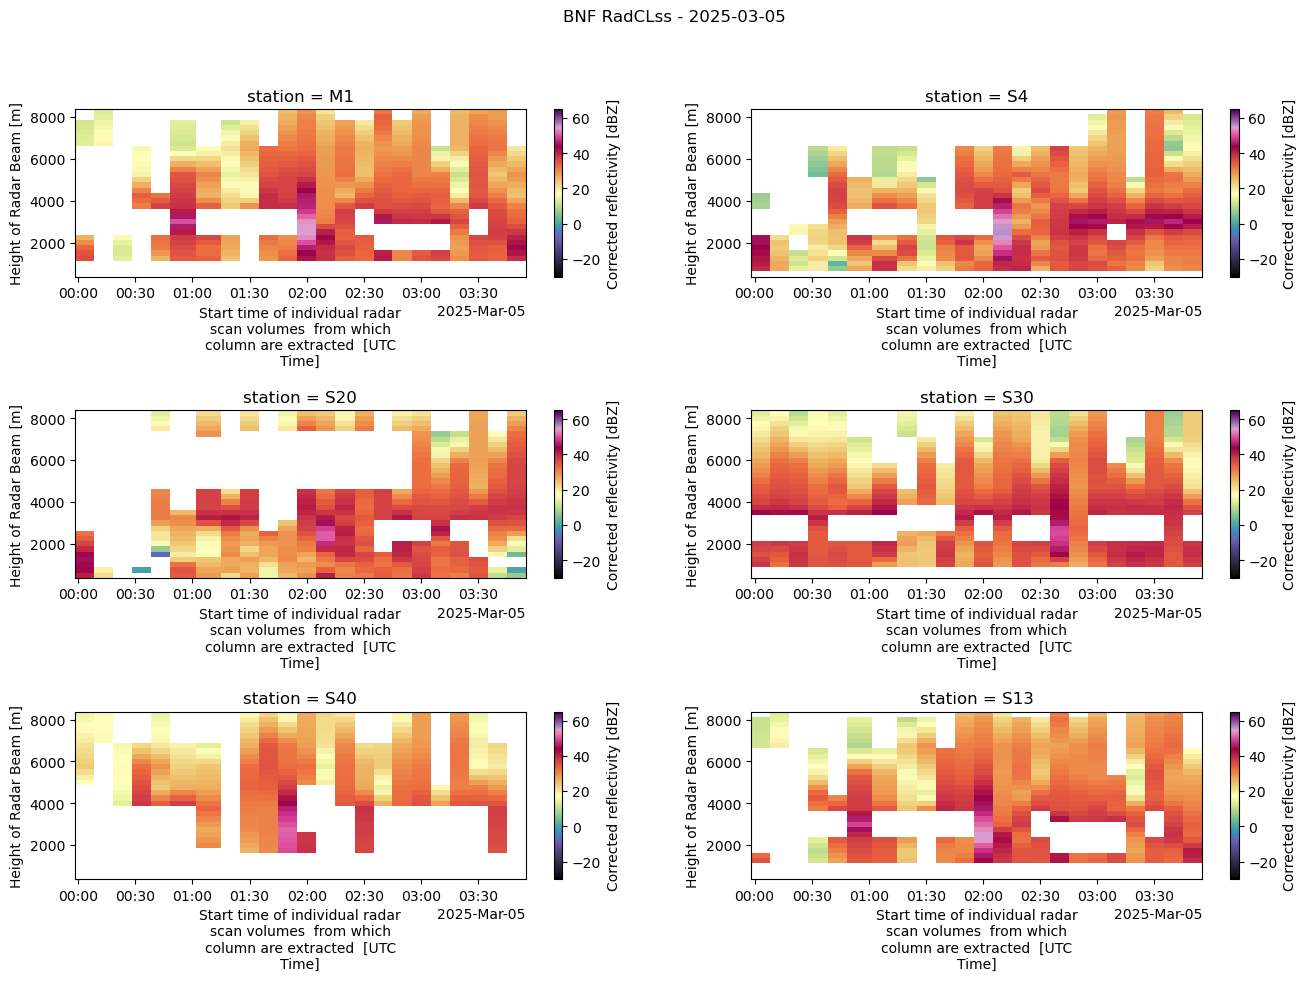

In [63]:
fig, axarr = plt.subplots(3, 2, figsize=[16, 10])
plt.subplots_adjust(hspace=0.8)

fig.suptitle("BNF RadCLss - " + DATE)

ds.sel(station="M1").sel(time=slice("2025-03-05T00:00:00", "2025-03-05T03:59:00")).corrected_reflectivity.plot(y="height", ax=axarr[0, 0], vmin=-30, vmax=65, cmap="ChaseSpectral")
ds.sel(station="S4").sel(time=slice("2025-03-05T00:00:00", "2025-03-05T03:59:00")).corrected_reflectivity.plot(y="height", ax=axarr[0, 1], vmin=-30, vmax=65, cmap="ChaseSpectral")
ds.sel(station="S20").sel(time=slice("2025-03-05T00:00:00", "2025-03-05T03:59:00")).corrected_reflectivity.plot(y="height", ax=axarr[1, 0], vmin=-30, vmax=65, cmap="ChaseSpectral")
ds.sel(station="S30").sel(time=slice("2025-03-05T00:00:00", "2025-03-05T03:59:00")).corrected_reflectivity.plot(y="height", ax=axarr[1, 1], vmin=-30, vmax=65, cmap="ChaseSpectral")
ds.sel(station="S40").sel(time=slice("2025-03-05T00:00:00", "2025-03-05T03:59:00")).corrected_reflectivity.plot(y="height", ax=axarr[2, 0], vmin=-30, vmax=65, cmap="ChaseSpectral")
ds.sel(station="S13").sel(time=slice("2025-03-05T00:00:00", "2025-03-05T03:59:00")).corrected_reflectivity.plot(y="height", ax=axarr[2, 1], vmin=-30, vmax=65, cmap="ChaseSpectral")

## Merge in the In-Situ Datastreams

In [64]:
for stream in insitu_stream:
    print(stream)

bnfmetM1.b1
bnfmetS20.b1
bnfmetS30.b1
bnfmetS40.b1
bnfsondewnpnM1.b1
bnfwbpluvio2M1.a1
bnfldquantsM1.c1
bnfldquantsS30.c1
bnfvdisquantsM1.c1
bnfmetwxtS13.b1


In [65]:
for stream in insitu_stream:
    if "bnfmet" in stream:
        if "wxt" not in stream:
            if "M1" in stream:
                met_list = sorted(glob.glob(insitu_stream[stream] + "/*" + DATE.replace('-', '') + '*.cdf'))
                if met_list:
                    ds = match_datasets_act(ds, 
                                            met_list[0],
                                            "M1",
                                            discard=discard_var['met'])
            else:
                met_list = sorted(glob.glob(insitu_stream[stream] + "/*" + DATE.replace('-', '') + '*.cdf'))
                met_site = met_list[0].split("/")[-1].split(".")[0][-3:]
                if met_list:
                    ds = match_datasets_act(ds, 
                                            met_list[0], 
                                            met_site, 
                                            discard=discard_var['met'])
    elif "bnfwbpluvio" in stream:
        insitu_list = sorted(glob.glob(insitu_stream[stream] + "/*" + DATE.replace('-', '') + '*.nc'))
        if insitu_list:
                ds = match_datasets_act(ds, 
                                        insitu_list[0], 
                                        "M1", 
                                        discard=discard_var['pluvio'])
    elif "bnfldquants" in stream:
        if "M1" in stream:
            insitu_list = sorted(glob.glob(insitu_stream[stream] + "/*" + DATE.replace('-', '') + '*.nc'))
            if insitu_list:
                ds = match_datasets_act(ds, 
                                        insitu_list[0], 
                                        "M1", 
                                        discard=discard_var['ldquants'],
                                        prefix="ldquants_")
        if "S30" in stream:
            insitu_list = sorted(glob.glob(insitu_stream["bnfldquantsS30.c1"] + "/*" + DATE.replace('-', '') + '*.nc'))
            if insitu_list:
                ds = match_datasets_act(ds, 
                                        insitu_list[0], 
                                        "S30", 
                                        discard=discard_var['ldquants'],
                                        prefix="ldquants_")
    elif "sonde" in stream:
        insitu_list = sorted(glob.glob(insitu_stream[stream] + "/*" + DATE.replace('-', '') + '*.cdf'))
        if insitu_list:
                ds = match_datasets_act(ds, 
                                        insitu_list[0], 
                                        "M1", 
                                        discard=discard_var['sonde'],
                                        resample="mean",
                                        prefix="sonde_")
    elif "wxt" in stream:
         if "S13" in stream:
            insitu_list = sorted(glob.glob(insitu_stream[stream] + "/*" + DATE.replace('-', '') + '*.nc'))
            if insitu_list:
                ds = match_datasets_act(ds, 
                                        insitu_list[0], 
                                        "S13", 
                                        discard=discard_var['wxt'],
                                        prefix="wxt_")
    elif "bnfvdisquants" in stream:
        if "M1" in stream:
            insitu_list = sorted(glob.glob(insitu_stream[stream] + "/*" + DATE.replace('-', '') + '*.nc'))
            if insitu_list:
                ds = match_datasets_act(ds, 
                                        insitu_list[0], 
                                        "M1", 
                                        discard=discard_var['vdisquants'],
                                        prefix="vdisquants_")
    else:
         continue

## Verify Data Standards

In [66]:
# verify the correct dimension order
ds = ds.transpose("time", "height", "station")

In [67]:
# call functions to define the DOD and adjust the RadCLss DataSet
ds = adjust_radclss_dod(ds, define_radclss_dod())

vdisquants_rain_rate
vdisquants_reflectivity_factor_cband20c
vdisquants_differential_reflectivity_cband20c
vdisquants_specific_differential_phase_cband20c
vdisquants_specific_attenuation_cband20c
vdisquants_med_diameter
vdisquants_mass_weighted_mean_diameter
vdisquants_lwc
vdisquants_total_droplet_concentration
vdisquants_mean_doppler_vel_cband20c
vdisquants_specific_differential_attenuation_cband20c
wxt_temp_mean
wxt_precip_rate_mean
wxt_cumul_precip


## Save the DataSet

In [78]:
# Define RADCLss keys to skip
keys_to_skip = ['alt', 
                'lat', 
                'lon', 
                'gate_time', 
                'station', 
                'base_time',
                'time_offset',
                'time']

# Define the keys that have int MVC
diff_keys = ['vdisquants_rain_rate',
             'vdisquants_reflectivity_factor_cband20c',
             'vdisquants_differential_reflectivity_cband20c',
             'vdisquants_specific_differential_phase_cband20c',
             'vdisquants_specific_attenuation_cband20c',
             'vdisquants_med_diameter',
             'vdisquants_mass_weighted_mean_diameter',
             'vdisquants_lwc',
             'vdisquants_total_droplet_concentration',
             'vdisquants_mean_doppler_vel_cband20c',
             'vdisquants_specific_differential_attenuation_cband20c',
             'wxt_temp_mean',
             'wxt_precip_rate_mean',
             'wxt_cumul_precip']

# Drop the missing value code attribute from the diff_keys
for key in diff_keys:
    if hasattr(ds[key], "missing_value"):
        del ds[key].attrs['missing_value']

# Create a dictionary to hold encoding information
filtered_keys = [key for key in ds.keys() if key not in {*keys_to_skip, *diff_keys}]
encoding_dict = {key : {"_FillValue" : -9999.} for key in filtered_keys}
diff_dict = {key : {"_FillValue" : -9999} for key in diff_keys}
encoding_dict.update(diff_dict)

In [79]:
encoding_dict

{'attenuation_corrected_differential_reflectivity': {'_FillValue': -9999.0},
 'attenuation_corrected_differential_reflectivity_lag_1': {'_FillValue': -9999.0},
 'attenuation_corrected_reflectivity_h': {'_FillValue': -9999.0},
 'copol_correlation_coeff': {'_FillValue': -9999.0},
 'corrected_velocity': {'_FillValue': -9999.0},
 'corrected_differential_phase': {'_FillValue': -9999.0},
 'filtered_corrected_differential_phase': {'_FillValue': -9999.0},
 'corrected_specific_diff_phase': {'_FillValue': -9999.0},
 'filtered_corrected_specific_diff_phase': {'_FillValue': -9999.0},
 'corrected_differential_reflectivity': {'_FillValue': -9999.0},
 'corrected_reflectivity': {'_FillValue': -9999.0},
 'rain_rate_A': {'_FillValue': -9999.0},
 'rain_rate_Z': {'_FillValue': -9999.0},
 'rain_rate_Kdp': {'_FillValue': -9999.0},
 'atmos_pressure': {'_FillValue': -9999.0},
 'temp_mean': {'_FillValue': -9999.0},
 'rh_mean': {'_FillValue': -9999.0},
 'vapor_pressure_mean': {'_FillValue': -9999.0},
 'wspd_ari

In [80]:
# define a filename
out_path = 'data/radclss/bnf-csapr2-radclss.c2.' + DATE.replace('-', '') + '.000000.nc'
# Convert DataSet to ACT DataSet for writing
ds_out = act.io.WriteDataset(ds)
# If FillValue set to True, will just apply NaNs instead of encodings
ds_out.write_netcdf(path=out_path,
                    FillValue=False,
                    encoding=encoding_dict)
#ds_out.write_netcdf(path=out_path,
#                    FillValue=False)

## References

### Surface Meteorological Instrumentation (MET)
- Kyrouac, J., Shi, Y., & Tuftedal, M. Surface Meteorological Instrumentation
(MET), 2025-03-05 to 2025-03-05, Bankhead National Forest, AL, USA; Long-term
Mobile Facility (BNF), Bankhead National Forest, AL, AMF3 (Main Site) **(M1)**.
Atmospheric Radiation Measurement (ARM) User Facility.
https://doi.org/10.5439/1786358

- Kyrouac, J., Shi, Y., & Tuftedal, M. Surface Meteorological Instrumentation
(MET), 2025-03-05 to 2025-03-05, Bankhead National Forest, AL, USA; Long-term
Mobile Facility (BNF), Bankhead National Forest, AL, Supplemental facility at
Courtland **(S20)**. Atmospheric Radiation Measurement (ARM) User Facility.
https://doi.org/10.5439/1786358

- Kyrouac, J., Shi, Y., & Tuftedal, M. Surface Meteorological Instrumentation
(MET), 2025-03-05 to 2025-03-05, Bankhead National Forest, AL, USA; Long-term
Mobile Facility (BNF), Bankhead National Forest, AL, Supplemental facility at
Falkville **(S30)**. Atmospheric Radiation Measurement (ARM) User Facility.
https://doi.org/10.5439/1786358

- Kyrouac, J., Shi, Y., & Tuftedal, M. Surface Meteorological Instrumentation
(MET), 2025-03-05 to 2025-03-05, Bankhead National Forest, AL, USA; Long-term
Mobile Facility (BNF), Bankhead National Forest, AL, Supplemental facility at
Double Springs **(S40)**. Atmospheric Radiation Measurement (ARM) User Facility.
https://doi.org/10.5439/1786358

### Balloon-Borne Sounding System (SONDEWNPN)
- Keeler, E., Burk, K., & Kyrouac, J. Balloon-Borne Sounding System (SONDEWNPN),
2025-03-05 to 2025-03-05, Bankhead National Forest, AL, USA; Long-term Mobile
Facility (BNF), Bankhead National Forest, AL, AMF3 (Main Site) **(M1)**. Atmospheric
Radiation Measurement (ARM) User Facility. https://doi.org/10.5439/1595321

### Weighing Bucket Preciptiation Gauge (WBPLUVIO2)
- Zhu, Z., Wang, D., Jane, M., Cromwell, E., Sturm, M., Irving, K., & Delamere, J.
Weighing Bucket Precipitation Gauge (WBPLUVIO2), 2025-03-05 to 2025-03-05,
Bankhead National Forest, AL, USA; Long-term Mobile Facility (BNF), Bankhead
National Forest, AL, AMF3 (Main Site) **(M1)**. Atmospheric Radiation Measurement
(ARM) User Facility. https://doi.org/10.5439/1338194

### Laser Disdrometer Quantities (LDQUANTS)
- Hardin, J., Giangrande, S., & Zhou, A. Laser Disdrometer Quantities (LDQUANTS),
2025-03-05 to 2025-03-05, Bankhead National Forest, AL, USA; Long-term Mobile
Facility (BNF), Bankhead National Forest, AL, AMF3 (Main Site) **(M1)**. Atmospheric
Radiation Measurement (ARM) User Facility. https://doi.org/10.5439/1432694

- Hardin, J., Giangrande, S., & Zhou, A. Laser Disdrometer Quantities (LDQUANTS),
2025-03-05 to 2025-03-05, Bankhead National Forest, AL, USA; Long-term Mobile
Facility (BNF), Bankhead National Forest, AL, Supplemental facility at Falkville
**(S30)**. Atmospheric Radiation Measurement (ARM) User Facility.
https://doi.org/10.5439/1432694

### Video Disdrometer Quantities (VDISQUANTS)
- Hardin, J., Giangrande, S., Fairless, T., & Zhou, A. Video Disdrometer VAP
(VDISQUANTS), 2025-05-24 to 2025-05-24, Bankhead National Forest, AL, USA; Long-
term Mobile Facility (BNF), Bankhead National Forest, AL, AMF3 (Main Site) (M1).
Atmospheric Radiation Measurement (ARM) User Facility.
https://doi.org/10.5439/1592683

### Vaisala Weather Transmitter (METWXT)
- Kyrouac, J., & Shi, Y. WXT520/530 Meteorological Instrument System (METWXT),
2025-05-24 to 2025-05-24, Bankhead National Forest, AL, USA; Long-term Mobile
Facility (BNF), Bankhead National Forest, AL, Supplemental facility for STAMP2
near Tower Site (S13). Atmospheric Radiation Measurement (ARM) User Facility.
https://doi.org/10.5439/1455447